# Test tiger with location scale regression

In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set path such that interpreter finds tigerpy
import sys
sys.path.append("..")

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi

# Use distributions and bijectors from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfjd

rng = np.random.default_rng(42)

## Simulate data

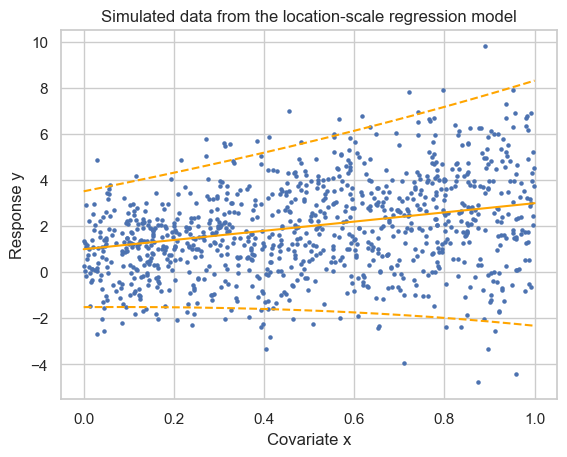

In [2]:
# Sample size and true parameters
n = 1000
true_beta = np.array([1.0, 2.0])
true_gamma = np.array([0.25, 0.75])

# Data-generating process
x0 = rng.uniform(size=n)
X_mat = np.column_stack([np.ones(n), x0])
Z_mat = np.column_stack([np.ones(n), x0])
log_sigma = Z_mat @ true_gamma
sigma = np.exp(log_sigma)
eps = rng.normal(scale=sigma, size=n)
response_vec = X_mat @ true_beta + eps

# Data to plot the linear regression line
x_plot = np.linspace(0, 1, num=200)
X_plot = np.column_stack([np.ones(200), x_plot])
Z_plot = np.column_stack([np.ones(200), x_plot])
mean_plot =  X_plot @ true_beta
sigma_plot = np.exp(Z_plot @ true_gamma)

# Set the seaborn theme
sns.set_theme(style="whitegrid")
# Plot the simulated data
plt.scatter(x0, response_vec, s = 5)
plt.plot(x_plot, mean_plot, color="orange")
plt.plot(x_plot, mean_plot - 1.96*sigma_plot, color="orange", linestyle="--")
plt.plot(x_plot, mean_plot + 1.96*sigma_plot, color="orange", linestyle="--")
plt.title("Simulated data from the location-scale regression model")
plt.xlabel("Covariate x")
plt.ylabel("Response y")
plt.show()

## Set up model in tigerpy

In [3]:
# Set up design matrix location
X = tiger.Obs(name = "X_loc")
X.fixed(data = x0)

# Set up design matrix scale
Z = tiger.Obs(name = "Z_scale")
Z.fixed(data = x0)

# Set up hyperparameters for the location
beta_loc = tiger.Hyper(0.0, name="beta_loc")
beta_scale = tiger.Hyper(100.0, name="beta_scale")

# Set up parameters for the location
beta_dist = tiger.Dist(tfjd.Normal, loc=beta_loc, scale=beta_scale)
beta = tiger.Param(value=np.array([0.0, 0.0]), distribution=beta_dist, name="beta")

# Set up hyperparameters for the scale
gamma_loc = tiger.Hyper(0.0, name="gamma_loc")
gamma_scale = tiger.Hyper(3.0, name="gamma_scale")

# Set up parameters for the scale
gamma_dist = tiger.Dist(tfjd.Normal, loc=gamma_loc, scale=gamma_scale)
gamma = tiger.Param(value=np.array([0.0, 0.0]), distribution=gamma_dist, name="gamma")

# Set up the linear predictors
lpred_loc = tiger.Lpred(obs=X, beta=beta)
lpred_scale = tiger.Lpred(obs=Z, function=jnp.exp, gamma=gamma)

# Set up response distribution
response_dist = tiger.Dist(tfjd.Normal, loc=lpred_loc, scale=lpred_scale)
m = tiger.Model(response=response_vec, distribution=response_dist)

In [4]:
jnp.sum(m.log_lik)

Array(-4782.4272, dtype=float32)

In [5]:
m.log_prior

Array(-15.08332, dtype=float32)

In [6]:
m.log_prob

Array(-4797.5107, dtype=float32)

In [7]:
graph = tiger.ModelGraph(model=m)
graph.build_graph()

In [8]:
graph.logprob()

Array(-4797.5107, dtype=float32)

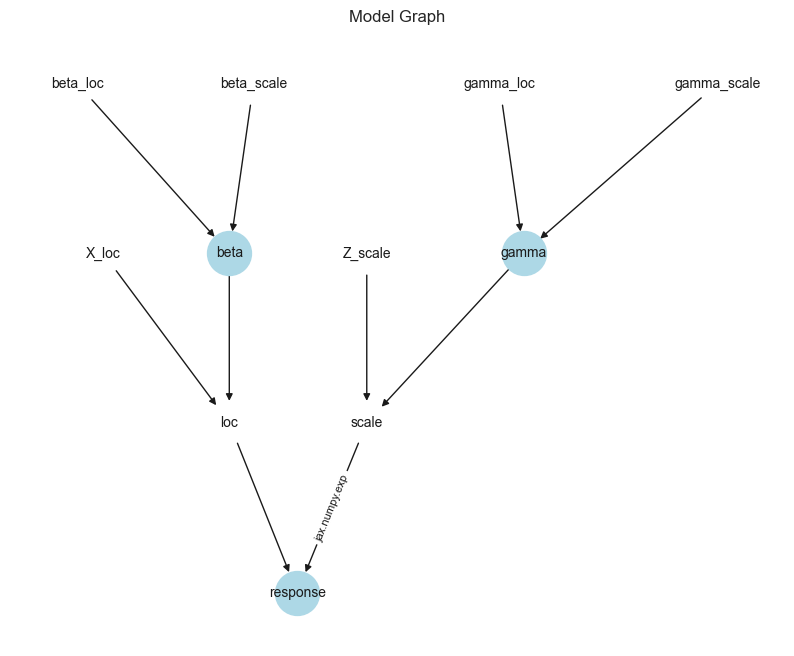

In [9]:
graph.visualize_graph()

## Inference with BBVI

In [10]:
q = bbvi.Bbvi(graph=graph)

In [11]:
import optax
schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.,
    peak_value=0.2,
    warmup_steps=100,
    decay_steps=2_000,
    end_value=0.001,
)

In [12]:
q.run_bbvi(step_size=0.01,
           threshold=1e-2,
           key_int=27,
           batch_size=128,
           num_var_samples=64,
           chunk_size=50,
           epochs=2500)

(Array(-1916.865, dtype=float32, weak_type=True),
 {'beta': {'loc': Array([0.72560376, 2.2905238 ], dtype=float32),
   'cov': Array([[ 0.01430931, -0.01457672],
          [-0.01457672,  0.04334948]], dtype=float32)},
  'gamma': {'loc': Array([0.32970265, 0.6620808 ], dtype=float32),
   'cov': Array([[ 0.01805938, -0.0124218 ],
          [-0.0124218 ,  0.03202613]], dtype=float32)}})

In [14]:
with jax.profiler.trace("/tmp/jax-trace", create_perfetto_link=True):
    q.run_bbvi(step_size=0.01,
               threshold=1e-2,
               key_int=27,
               batch_size=128,
               num_var_samples=64,
               chunk_size=50,
               epochs=2500)

Open URL in browser: https://ui.perfetto.dev/#!/?url=http://127.0.0.1:9001/perfetto_trace.json.gz


127.0.0.1 - - [04/Oct/2023 11:50:18] code 404, message File not found
127.0.0.1 - - [04/Oct/2023 11:50:18] "POST /status HTTP/1.1" 404 -
127.0.0.1 - - [04/Oct/2023 11:50:18] "GET /perfetto_trace.json.gz HTTP/1.1" 200 -


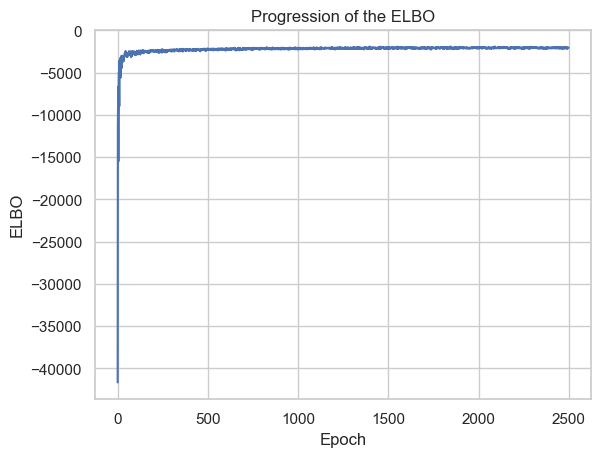

In [15]:
q.plot_elbo()